In [796]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import mode
from itertools import combinations
import cvxopt #pip install cvxopt
import matplotlib.pyplot as plt

class SVMBase1:
    def __init__(self, learning_rate=0.001, _lambda=0.01, nb_epoch=1000):
        self.learning_rate = learning_rate
        self._lambda = _lambda
        self.nb_epoch = nb_epoch
        self.W = None
        self.b = None
    def fit_base(self, X, y):
        nb_rows, nb_feature = X.shape
        #Gradiant descent
        self.W = np.zeros(nb_feature)
        self.b = 0

        for _ in range(self.nb_epoch):
            for i in range(nb_rows):
                if y[i]*(np.dot(self.W, X[i]) - self.b) >= 1 :
                    self.W -= self.learning_rate*(2*self._lambda * self.W)
                else:
                    self.W -= self.learning_rate * (2 * self._lambda * self.W - np.dot(X[i], y[i]))
                    self.b -= self.learning_rate * y[i]
    
    def predict_base(self, X):
        output = np.dot(X, self.W) - self.b
        return np.sign(output)
    
    def decision_base(self, X):
        return np.dot(X, self.W) - self.b

class SVMBase2:
    def __init__(self, kernel="linear", C=1.0):
        self.kernel = kernel
        self.C = C
        self.X = None
        self.y = None
        self.alpha = None
        self.W = None
        self.b = None
        self.sv = None
        if kernel == "linear":
            self.kernel = self.linear
        elif kernel == 'gaussian':
            self.kernel = self.gaussian
        elif kernel == 'polynomial':
            self.kernel = self.polynomial
        
    def fit_base(self, X, y):
        self.X = np.array(X)
        self.y = np.array(y)
        n, m = self.X.shape
        K = np.zeros((n,n))
        for i in range(n):
            K[i,:] = self.kernel(self.X[i, np.newaxis], self.X)
        P = cvxopt.matrix(np.outer(self.y, self.y) * K)
        q = cvxopt.matrix(-np.ones((n,1)))
        G = cvxopt.matrix(np.vstack((np.eye(n)* - 1, np.eye(n))))
        h = cvxopt.matrix(np.hstack((np.zeros(n), np.ones(n) * self.C)))
        A = cvxopt.matrix(self.y, (1, n), 'd')
        b = cvxopt.matrix(np.zeros(1))
        cvxopt.solvers.options['show_progress'] = False
    
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)
        self.alpha = np.array(solution['x'])
        
        threshold = 1e-4
        self.sv = ((self.alpha > threshold) * (self.alpha < self.C)).flatten()
        self.W = np.dot(self.X[self.sv].T, self.alpha[self.sv] * self.y[self.sv, np.newaxis])
        self.b = np.mean(self.y[self.sv, np.newaxis] - self.alpha[self.sv] * self.y[self.sv, np.newaxis] * K[self.sv,self.sv][:, np.newaxis])
        
    def predict_base(self, X):
        n = X.shape[0]
        y_predict = np.zeros(n)
        for i in range(n):
            y_predict[i] = np.sum(self.alpha[self.sv] * self.y[self.sv, np.newaxis] * self.kernel(X[i], self.X[self.sv])[:,np.newaxis])
        
        return np.sign(y_predict + self.b)
    
    def decision_base(self, X):
        n = X.shape[0]
        y_predict = np.zeros(n)
        for i in range(n):
            y_predict[i] = np.sum(self.alpha[self.sv] * self.y[self.sv, np.newaxis] * self.kernel(X[i], self.X[self.sv])[:,np.newaxis])
        return y_predict + self.b
         
    def linear(self, X, Z):
        return np.dot(X, Z.T)
    
    def gaussian(self, X, Z, sigma=0.1):
        return np.exp(-np.linalg.norm(X-Z, axis=1)**2 / (2*(sigma**2)))
    
    def polynomial(self, X, Z, p=5):
        return (1 + np.dot(X, Z.T)) ** p
    
class SVM(SVMBase1, SVMBase2):
    def __init__(self, learning_rate=0.001, _lambda=0.01, nb_epoch=1000, decision='ova', kernel= None, C=1.0):
        self.learning_rate = learning_rate
        self._lambda = _lambda
        self.nb_epoch = nb_epoch
        self.labels = None
        self.nb_label = None
        self.kernel = kernel
        self.decision = decision
        self.classifiers = []
        self.class_pairs = []
        SVMBase1.__init__(self, learning_rate=learning_rate, _lambda=_lambda, nb_epoch=nb_epoch)
        SVMBase2.__init__(self, kernel=kernel, C=C)
        
    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        self.labels = list(np.unique(y))
        self.nb_label = len(self.labels)
        y = np.array([self.labels.index(yi) for yi in y])
        if self.kernel == None:
            self.fit_classification(SVMClass = SVMBase1, X=X, y=y)
        else:
            self.fit_classification(SVMClass = SVMBase2, X=X, y=y)
                
    def fit_classification(self, SVMClass, X, y):
        y_unique = np.unique(y)
        if self.nb_label == 2:
            y = np.where(y == 1, 1, -1)
            SVMClass.fit_base(self, X=X, y=y)
        elif self.decision == 'ova':
            y_list = [np.where(y == label, 1, -1) for label in y_unique]
            for y_i in y_list:
                svm1 = SVMClass()
                svm1.fit_base(X, y_i)
                self.classifiers.append(svm1)
        elif self.decision == 'ovo':
            self.class_pairs = list(combinations(y_unique, 2))
            for class_pair in self.class_pairs:
                indexs = np.where((y == class_pair[0]) | (y == class_pair[1]))
                y_i = np.where(y[indexs] == class_pair[0], 1, -1)
                clf = SVMClass()
                clf.fit_base(X[indexs], y_i)
                self.classifiers.append(clf)
                
    def predict(self, X):
        result = self.predict_points(X)
        return np.array([self.labels[i] for i in result])
    
    def predict_points(self, X):
        X = np.array(X)
        if self.kernel == None:
            return self.predict_point_classification(predict = SVMBase1.predict_base, X=X)
        else:
            return self.predict_point_classification(predict = SVMBase2.predict_base, X=X)
    
    def predict_point_classification(self, predict, X):
        if self.nb_label == 2:
            result = predict(self, X=X)
            result = np.where(result == 1, 1, 0)
        elif self.decision == 'ova':
            result = self.predict_multiclass_ova(X)
        elif self.decision == 'ovo':
            result = self.predict_multiclass_ovo(X)
        return result
        
    def predict_multiclass_ova(self, X):
        predictions = np.zeros((X.shape[0], len(self.classifiers)))
        for idx, clf in enumerate(self.classifiers):
            predictions[:, idx] = clf.decision_base(X)
        # return the argmax of the decision function as suggested by Vapnik.
        return np.argmax(predictions, axis=1)

    def predict_multiclass_ovo(self, X):
        predictions = np.zeros((X.shape[0], len(self.classifiers)))
        for idx, clf in enumerate(self.classifiers):
            class_pair = self.class_pairs[idx]
            prediction = clf.predict_base(X)
            predictions[:, idx] = np.where(prediction == 1, class_pair[0], class_pair[1])
        return mode(predictions, axis=1)[0].ravel().astype(int)
    
    def score(self, y_true, y_predict):
        return np.sum(y_true == y_predict) / len(y_true)
 
    def plot_contours(self, X, y):
        X = np.array(X)
        y = np.array(y)
        if len(X[0,:]) > 2:
            print("Can't display graph...")
            return
        y = np.array([self.labels.index(yi) for yi in y])
        # plot the resulting classifier
        h = 0.01
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        points = np.c_[xx.ravel(), yy.ravel()]
        if self.nb_label == 2:
            Z = self.predict_points(points)
        elif self.decision == 'ova':
            Z = self.predict_multiclass_ova(points)
        elif self.decision == 'ovo':
            Z = self.predict_multiclass_ovo(points)
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
        # plt the points
        plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)
        plt.show()
        

In [797]:
from sklearn import datasets
def load_data(k):
    if k == 0:
        X = np.array([[4, 2], [4, 3], [5, 1], [5, 2],
                     [5, 3], [6, 1], [6, 2], [9, 4],
                     [9, 7], [10, 5], [10, 6], [11, 6]])
        y = np.array([1,1,1,1,1,1,1,-1,-1,-1,-1,-1])
        #['yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'no', 'no','no', 'no']
    elif k == 1:
        X = np.array([[1, 6], [1, 7], [2, 5], [2, 8],
                     [4, 2], [4, 3], [5, 1], [5, 2],
                     [5, 3], [6, 1], [6, 2], [9, 4],
                     [9, 7], [10, 5], [10, 6], [11, 6],
                     [5, 9], [5, 10], [5, 11], [6, 9],
                     [6, 10], [7, 10], [8, 11]])
        y = np.array([1, 1, 1, 1,
                     2, 2, 2, 2, 2, 2, 2,
                     3, 3, 3, 3, 3,
                     4, 4, 4, 4, 4, 4, 4])
    elif k == 2:
        X, y =  datasets.make_blobs(n_samples=50, n_features=2, centers=2, cluster_std=1.05, random_state=40)
    elif k == 3:
        iris = datasets.load_iris()
        data = pd.DataFrame(iris.data, columns=iris.feature_names)
        data["label"] = iris.target
        X, y  = data.drop("label", axis=1), data["label"].values
    elif k == 4:
        N = 50
        K = 2
        D = 2
        X = np.zeros((N * K, D))  # data matrix (each row = single example)
        y = np.zeros(N * K)  # class labels

        for j in range(K):
            ix = range(N * j, N * (j + 1))
            r = np.linspace(0.0, 1, N)  # radius
            t = np.linspace(j * 4, (j + 1) * 4, N) + np.random.randn(N) * 0.2  # theta
            X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
            y[ix] = j

        # lets visualize the data:
        plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
        plt.show()

        y[y == 0] -= 1
    return X, y
        


X, y = load_data(1)

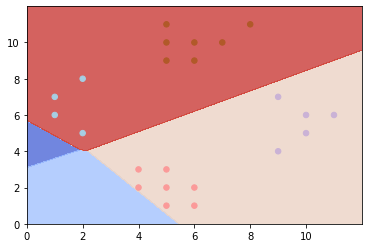

y in: [1 1 1 1 2 2 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 4 4]
y out  [4 4 4 4 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4]
Accuracy : 0.5217391304347826


In [801]:
#With Kernel
modele = SVM(kernel='linear')
modele.fit(X, y)
predictions = modele.predict(X)
score = modele.score(y, predictions)
modele.plot_contours(X, y)
print("y in:", y)
print("y out ",predictions)
print("Accuracy :",score)

<class '__main__.SVMBase1'>
No kernel
[ 1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1.]
[1 1 1 1 1 1 1 0 0 0 0 0]
No kernel
[ 1.  1.  1. ... -1. -1. -1.]


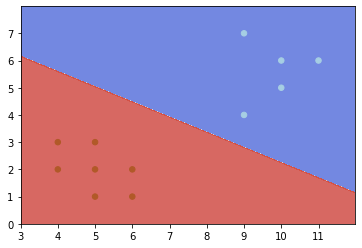

y in: [ 1  1  1  1  1  1  1 -1 -1 -1 -1 -1]
y out  [ 1  1  1  1  1  1  1 -1 -1 -1 -1 -1]
Accuracy : 1.0


In [508]:
#Linear
svm = SVM(decision='ovo')
svm.fit(X, y)
predictions = svm.predict(X)
score = svm.score(y, predictions)
svm.plot_contours(X, y)
print("y in:", y)
print("y out ",predictions)
print("Accuracy :",score)

In [500]:
#Kernel
modele = SVMBase2()
modele.fit(X, y)
predictions = modele.predict(X)
score = modele.score(y, predictions)
modele.plot_contours(X, y)
print(y)
print(predictions)
print(score)

TypeError: __init__() missing 2 required positional arguments: 'kernel' and 'C'

In [501]:
y = ['yes', 'no', 'yes', 'inter', 'inter', 'no', 'yes']
#y = np.array([1, 1, 1, 1,2, 2, 2, 2, 2, 2, 2,3, 3, 3, 3, 3,4, 4, 4, 4, 4, 4, 4])
y = ['yes', 'no', 'yes','yes', 'no', 'yes']
y = [1,-1,-1,1,-1]
print("Input: ",y)

labels = list(np.unique(y))
y = np.array([labels.index(yi) for yi in y])
if len(labels) == 2:
    y = np.where(y == 1, 1, -1)
    
print("Labels: ",labels)
print("Classes: ",y)
result = np.array([-1,1,-1,-1,1])
#result = [2, 1,0,1]
print("result 1:",result)

if len(labels) == 2:
    result = np.where(result == 1, 1, 0)

print("result 1:",result)


output = np.array([labels[i] for i in result])
print("Out put :",output)

Input:  [1, -1, -1, 1, -1]
Labels:  [-1, 1]
Classes:  [ 1 -1 -1  1 -1]
result 1: [-1  1 -1 -1  1]
result 1: [0 1 0 0 1]
Out put : [-1  1 -1 -1  1]


In [152]:
modele = SVM()

modele.fit(X, y)
predictions = modele.predict(X)
score = modele.score(y, predictions)
modele.plot_contours(X, y)
print(y)
print(predictions)
print(score)

IndexError: index 6 is out of bounds for axis 0 with size 6

In [ ]:
import cvxopt #pip install cvxopt
class SVMBase3:
    def __init__(self, kernel='linear', C=1):
        self.C = C
        self.X = None
        self.y = None
        self.alpha = None
        self.W = None
        self.b = None
        self.sv = None
        if kernel == "linear":
            self.kernel = self.linear
        elif kernel == 'gaussian':
            self.kernel = self.gaussian
        elif kernel == 'polynomial':
            self.kernel = self.polynomial
        
    def fit_base(self, X, y):
        self.X = np.array(X)
        self.y = np.array(y)
        n, m = self.X.shape
        K = np.zeros((n,n))
        for i in range(n):
            K[i,:] = self.kernel(self.X[i, np.newaxis], self.X)
        P = cvxopt.matrix(np.outer(self.y, self.y) * K)
        q = cvxopt.matrix(-np.ones((n,1)))
        G = cvxopt.matrix(np.vstack((np.eye(n)* - 1, np.eye(n))))
        h = cvxopt.matrix(np.hstack((np.zeros(n), np.ones(n) * self.C)))
        A = cvxopt.matrix(self.y, (1, n), 'd')
        b = cvxopt.matrix(np.zeros(1))
        cvxopt.solvers.options['show_progress'] = False
    
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)
        self.alpha = np.array(solution['x'])
        
        threshold = 1e-4
        self.sv = ((self.alpha > threshold) * (self.alpha < self.C)).flatten()
        self.W = np.dot(self.X[self.sv].T, self.alpha[self.sv] * self.y[self.sv, np.newaxis])
        self.b = np.mean(self.y[self.sv, np.newaxis] - self.alpha[self.sv] * self.y[self.sv, np.newaxis] * K[self.sv,self.sv][:, np.newaxis])
        
    def predict_base(self, X):
        n = X.shape[0]
        y_predict = np.zeros(n)
        for i in range(n):
            y_predict[i] = np.sum(self.alpha[self.sv] * self.y[self.sv, np.newaxis] * self.kernel(X[i], self.X[self.sv])[:,np.newaxis])
        return np.sign(y_predict + self.b)
           
    def linear(self, X, Z):
        return np.dot(X, Z.T)
    
    def gaussian(self, X, Z, sigma=0.1):
        return np.exp(-np.linalg.norm(X-Z, axis=1)**2 / (2*(sigma**2)))
    
    def polynomial(self, X, Z, p=5):
        return (1 + np.dot(X, Z.T)) ** p
    
    def score(self, y_true, y_predict):
        return np.sum(y_true == y_predict) / len(y_true)
    
    def plot_contours(self, X, y):
        X = np.array(X)
        y = np.array(y)
        # plot the resulting classifier
        h = 0.01
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        points = np.c_[xx.ravel(), yy.ravel()]
        
        Z = self.predict_base(points)
            
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

        # plt the points
        plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)
        plt.show()

In [ ]:
from sklearn import svm
def SVM_ScikitLearn(X, y, kernel='linear'):
    def plot_contours(X, y, svm):
        # plot the resulting classifier
        h = 0.01
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        points = np.c_[xx.ravel(), yy.ravel()]

        Z = svm.predict(points)
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

        # plt the points
        #plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.coolwarm)
        plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)
        plt.show()

    def plot_contour(X, y, classifiers):
        # plot the resulting classifier
        h = 0.01
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        points = np.c_[xx.ravel(), yy.ravel()]

        Z = predict_class(points, classifiers)
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

        # plt the points
        #plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.coolwarm)
        plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)
        plt.show()
    def predict_class(X, classifiers):
        predictions = np.zeros((X.shape[0], len(classifiers)))
        for idx, clf in enumerate(classifiers):
            predictions[:, idx] = clf.decision_function(X)
        # return the argmax of the decision function as suggested by Vapnik.
        return np.argmax(predictions, axis=1) + 1
            
    labels = np.unique(y)
    y_list = [np.where(y == label, 1, -1) for label in labels]
    classifiers = []
    for y_i in y_list:
        clf = svm.SVC(kernel='linear', C=1000)
        clf.fit(X, y_i)
        classifiers.append(clf)
        plot_contours(X, y, clf)
    plot_contour(X, y, classifiers)

In [ ]:
SVM_ScikitLearn(X, y)

In [ ]:
X = load_X(1)
y = load_y(1)
# Create datasets.
def predict_classovo(X, classifiers, class_pairs):
    predictions = np.zeros((X.shape[0], len(classifiers)))
    for idx, clf in enumerate(classifiers):
        class_pair = class_pairs[idx]
        prediction = clf.predict(X)
        predictions[:, idx] = np.where(prediction == 1,

                                       class_pair[0], class_pair[1])
    return mode(predictions, axis=1)[0].ravel().astype(int)

def plot_contours(X, y, classifiers, class_pairs):
    # plot the resulting classifier
    h = 0.01
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    points = np.c_[xx.ravel(), yy.ravel()]

    Z = predict_classovo(points, classifiers, class_pairs)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    # plt the points
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)
    plt.show()

In [ ]:
class_pairs = list(combinations(set(y), 2))
classifiers= []
for class_pair in class_pairs:
    indexs = np.where((y == class_pair[0]) | (y == class_pair[1]))
    y_i = np.where(y[indexs] == class_pair[0], 1, -1)
    clf = svm.SVC(kernel='linear', C=1000)
    clf.fit(X[indexs], y_i)
    classifiers.append(clf)
plot_contours(X, y, classifiers, class_pairs)

In [13]:
a=3
if a == 1:
    print("11111")
elif a == 2:
    print("222222")
elif a == 3:
    print("333333")

333333


In [211]:
a = np.array([1,1,1,1,1,1,1,0,0,0,0,0])
a = np.where(a == 1, "yes", "no")
a

array(['yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'no', 'no',
       'no', 'no'], dtype='<U3')

In [713]:
import numpy as np
from collections import Counter
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, * , value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
    
    def is_leaf_node(self):
        return self.value is not None

class DecisionTree:
    def __init__(self, min_rows_split=2, max_depth=100, nb_features=None):
        self.min_rows_split = min_rows_split
        self.max_depth = max_depth
        self.nb_features = nb_features
        self.root = None
    
    def fit(self, X, y):
        X = np.array(X)
        self.nb_features = X.shape[1] if not self.nb_features else min(self.nb_features, X.shape[1])
        self.root = self.build_tree(X,y)
    
    def build_tree(self, X, y, depth=0):
        nb_rows, nb_feats = X.shape
        nb_labels = len(np.unique(y))
        if depth >= self.max_depth or nb_labels == 1 or nb_rows < self.min_rows_split:
            leaf_value = Counter(y).most_common(1)[0][0] #Get the most common label in all rows
            return Node(value=leaf_value)
        
        feats_index = np.random.choice(nb_feats, self.nb_features, replace=False) #create self.nb_features random list between 0-nb_feats with no repeat
        #greedy search
        best_feat, best_thresh = self.best_criteria(X, y, feats_index)
        #Generate split
        left_index = np.argwhere(X[:,best_feat] <= best_thresh).flatten()
        right_index = np.argwhere(X[:,best_feat] > best_thresh).flatten()
        #Build Child tree
        left = self.build_tree(X[left_index,:], y[left_index], depth+1)
        right = self.build_tree(X[right_index,:], y[right_index], depth+1)
        return Node(best_feat, best_thresh, left, right)

    
    def best_criteria(self, X, y, feats_index):
        best_gain = -1
        split_col, split_thresh = None, None
        #Loop over features index and then over each threshold
        for col_index in feats_index:
            X_column = X[:,col_index]
            thresholds = np.unique(X_column)
            for  thresh in thresholds:
                gain = self.information_gain(X_column, y, thresh) # Calculate information Gain
                if gain > best_gain:
                    best_gain = gain
                    split_col = col_index
                    split_thresh = thresh
        return split_col, split_thresh
    
    def information_gain(self, x, y, thresh):
        #parent entropy
        parent_entropy = self.entropy(y)
        #Generate split
        left_index = np.argwhere(x <= thresh).flatten()
        right_index = np.argwhere(x > thresh).flatten()

        len_l, len_r = len(left_index), len(right_index)
        if len_l == 0 or len_r == 0:
            return 0
        #Weighted average for childs
        len_y = len(y)
        left_entropy = self.entropy(y[left_index])
        right_entropy = self.entropy(y[right_index])
        childs_entropy = (len_l/len_y)*left_entropy + (len_r/len_y)*right_entropy
        #Info gain
        info_gain = parent_entropy - childs_entropy
        return info_gain
        

    def entropy(self, label):
        hist = np.bincount(label)
        proba = hist / len(label)
        entropy = -np.sum([p * np.log2(p) for p in proba if p > 0])
        return entropy

    #Prediction function
    def predict(self, X):
        X = np.array(X)
        return np.array([self.traverse_tree(x, self.root) for x in X])
    
    def traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value
        if x[node.feature] <= node.threshold:
            return self.traverse_tree(x, node.left)
        return self.traverse_tree(x, node.right)

    #Score of prediction
    def score(self, y_true, y_predict):
        return np.sum(y_true == y_predict) / len(y_true)
    
    def drow_graph(self, DT, features, labels):
        fig = plt.figure(figsize=(25,20))
        _ = tree.plot_tree(DT, feature_names=features,  
                           class_names=labels.astype(str),
                           filled=True)
        fig.show()
    
    



In [726]:
def drow_graph(DT, features, labels):
    fig = plt.figure(figsize=(25,20))
    _ = tree.plot_tree(DT, feature_names=features,  
                       class_names=labels.astype(str),
                       filled=True)
    fig.show()

The accuracy is:  1.0


/home/komlan/anaconda3/envs/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


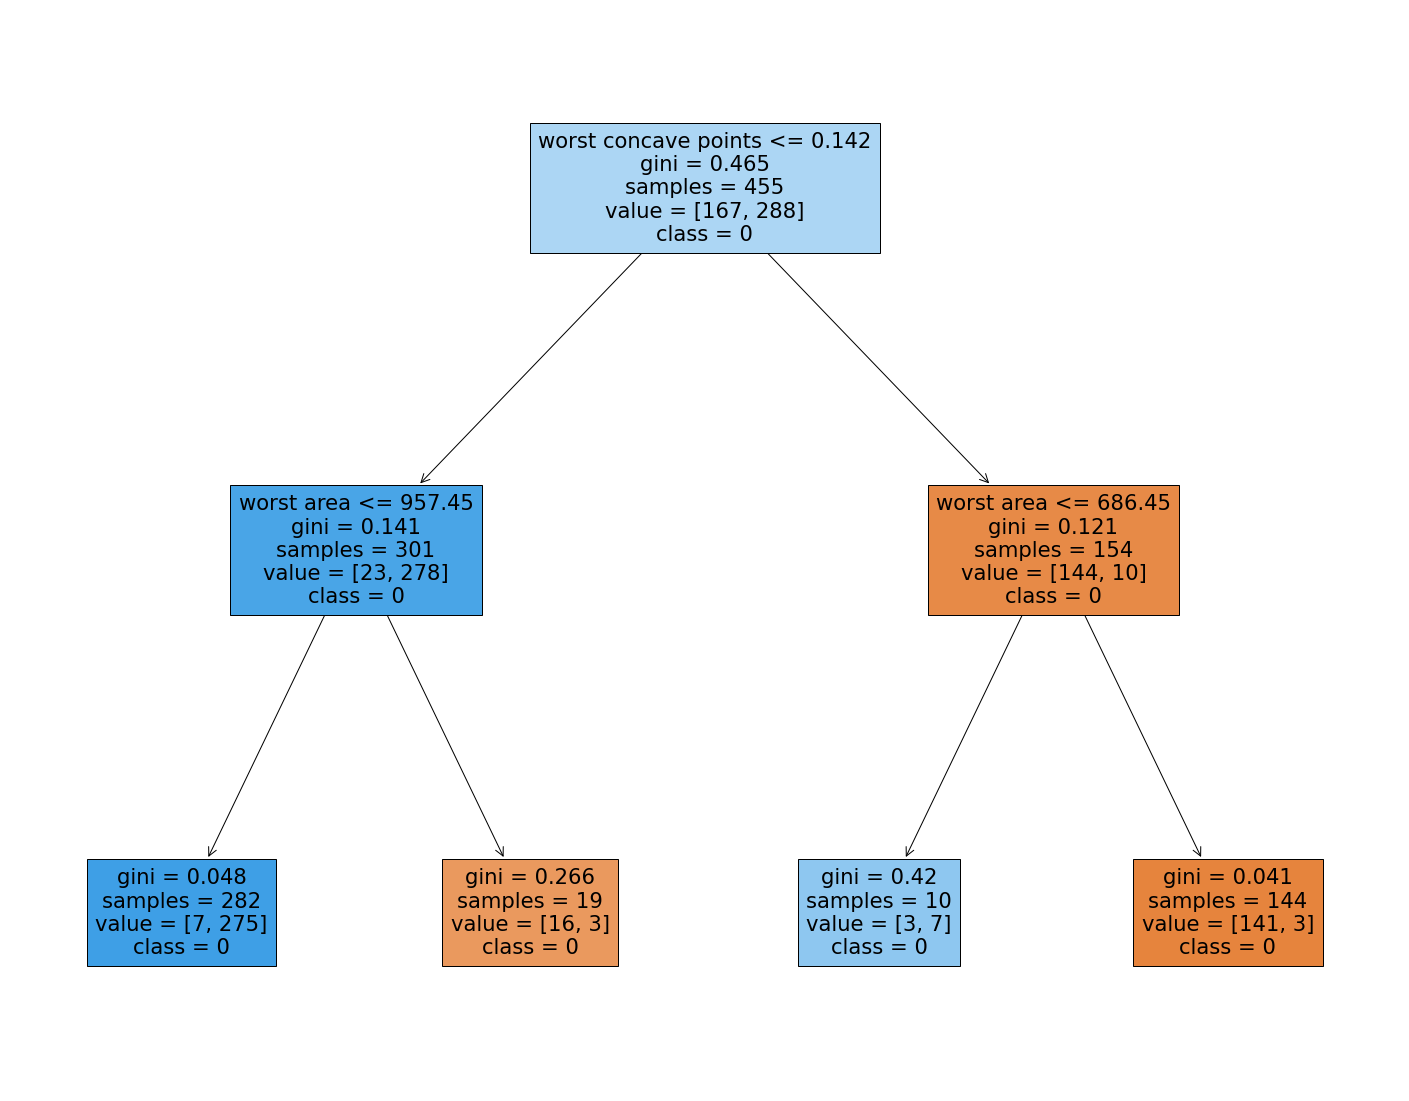

In [730]:
from sklearn import datasets
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split

# Your code goes here
import pandas as pd
dat = datasets.load_breast_cancer()
data = pd.DataFrame(dat.data, columns=dat.feature_names)
data["label"] = dat.target
X = data.drop('label', axis=1).values# Input features (attributes)
y = data['label'].values
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8, test_size=0.2, random_state=1234)

DT = DecisionTree(max_depth=3)
#DT = DecisionTreeClassifier(max_depth=2)
DT.fit(X_train, y_train)

y_pred = DT.predict(X_test)
score = DT.score(y_test, y_pred)
print("The accuracy is: ", score)
#DT.drow_graph(DT, data.columns, data['label'].values)

In [682]:
dat = datasets.load_breast_cancer()
dat.feature_names

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

In [793]:
import numpy as np
class KNN:
    def __init__(self, K = 5):
        self.K = K
    
    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        self.X = X.astype(np.int64)
        self.y = y
        self.labels = list(np.unique(self.y))
    
    def predict(self, X):
        X = np.array(X)
        #X = X.astype(np.int64)
        results = []
        for x in X:
            results.append(self.predict_element(x))
        return np.array(results)
    
    def predict_element(self, a):
        #Calculate distance from x to all element in the dataset
        list_dist = []
        for x, y in zip(self.X, self.y):
            dist = ((a - x) ** 2).sum()
            list_dist.append([dist, y])
        list_dist = sorted(list_dist, key=lambda li: li[0]) #sort the list according to the distance at the first column
        k_nearest = list_dist[:self.K] #Get the K first smallest datas
        y = np.array(k_nearest)[:,1]
        labels, counts = np.unique(y, return_counts=True) 
        best_label = labels[np.argmax(counts)]
        return best_label
    
    def score(self, y_true, y_predict):
        return np.sum(y_true == y_predict) / len(y_true)
    
    def plot_contours(self, X, y):
        X = np.array(X)
        if len(X[0,:]) > 2:
            print("Can't display graph...")
            return
        y = np.array(y)
        # plot the resulting classifier
        h = 0.01
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        points = np.c_[xx.ravel(), yy.ravel()]

        Z = self.predict(points)
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

        # plt the points
        #plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.coolwarm)
        plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)
        plt.show()



In [794]:
from sklearn import datasets
import pandas as pd
def load_data(k):
    if k == 0:
        X = np.array([[4, 2], [4, 3], [5, 1], [5, 2],
                     [5, 3], [6, 1], [6, 2], [9, 4],
                     [9, 7], [10, 5], [10, 6], [11, 6]])
        y = np.array([1,1,1,1,1,1,1,-1,-1,-1,-1,-1])
        #['yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'no', 'no','no', 'no']
    elif k == 1:
        X = np.array([[1, 6], [1, 7], [2, 5], [2, 8],
                     [4, 2], [4, 3], [5, 1], [5, 2],
                     [5, 3], [6, 1], [6, 2], [9, 4],
                     [9, 7], [10, 5], [10, 6], [11, 6],
                     [5, 9], [5, 10], [5, 11], [6, 9],
                     [6, 10], [7, 10], [8, 11]])
        y = np.array([1, 1, 1, 1,
                     2, 2, 2, 2, 2, 2, 2,
                     3, 3, 3, 3, 3,
                     4, 4, 4, 4, 4, 4, 4])
    elif k == 2:
        X, y =  datasets.make_blobs(n_samples=50, n_features=2, centers=2, cluster_std=1.05, random_state=40)
    elif k == 3:
        iris = datasets.load_iris()
        data = pd.DataFrame(iris.data, columns=iris.feature_names)
        data["label"] = iris.target
        X, y  = data.drop("label", axis=1), data["label"].values
    elif k == 4:
        N = 50
        K = 2
        D = 2
        X = np.zeros((N * K, D))  # data matrix (each row = single example)
        y = np.zeros(N * K)  # class labels

        for j in range(K):
            ix = range(N * j, N * (j + 1))
            r = np.linspace(0.0, 1, N)  # radius
            t = np.linspace(j * 4, (j + 1) * 4, N) + np.random.randn(N) * 0.2  # theta
            X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
            y[ix] = j

        # lets visualize the data:
        plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
        plt.show()

        y[y == 0] -= 1
    return X, y
        


X, y = load_data(1)

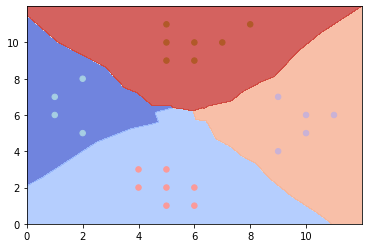

y in:  [1 1 1 1 2 2 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 4 4]
y out:  [1 1 1 1 2 2 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 4 4]
The accuracy is:  1.0


In [795]:
knn = KNN(K=5)
knn.fit(X, y)
y_predict = knn.predict(X)
score = knn.score(y, y_predict)
knn.plot_contours(X, y)
print("y in: ", y)
print("y out: ", y_predict)
print("The accuracy is: ", score)

In [762]:
y = np.array([1,1,1,1,1,1,1,-1,-1,-1,-1,-1])
labels = list(np.unique(y))
y = np.array([labels.index(yi) for yi in y])
print(y)
or = np.array([labels[i] for i in y])

[1 1 1 1 1 1 1 0 0 0 0 0]


array([ 1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1])